# Exemplo U-NET
### O exemplo que se segue foi construido a partir do código original disponivel no seguinte github:
https://github.com/zhixuhao/unet

Python 3.6

# 1. Data augmentation

In deep learning tasks, a lot of data is need to train DNN model, when the dataset is not big enough, data augmentation should be applied.

keras.preprocessing.image.ImageDataGenerator is a data generator, which can feed the DNN with data like : (data,label), it can also do data augmentation at the same time.

It is very convenient for us to use keras.preprocessing.image.ImageDataGenerator to do data augmentation by implement image rotation, shift, rescale and so on... see [keras documentation](https://keras.io/preprocessing/image/) for detail.

For image segmentation tasks, the image and mask must be transformed **together!!**


## Auxiliar functions

### "adjustData" -  Normalizes data


In [1]:
def adjustData(img,mask):
    if(np.max(img) > 1):
        img = img / 255
        mask = mask /255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
        
    return (img,mask)

### "trainGenerator" - Generate image and mask at the same time 

use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same

if you want to visualize the results of generator, set save_to_dir = "your path"

In [2]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np 

def trainGenerator(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    save_to_dir = None,target_size = (256,256), seed = 1):
    
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask)
        yield (img,mask)

Using TensorFlow backend.


## 1.1. Define your data generator

A) If you want to visualize your data augmentation result, set save_to_dir = your path

B) If you don't want to do data augmentation, set data_gen_args as an empty dict. 


Ex: data_gen_args = dict()


In [3]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')

myGene = trainGenerator(batch_size = 20,
                             train_path = 'data/membrane/train',
                             image_folder = 'image',
                             mask_folder = 'label',
                             aug_dict = data_gen_args,
                             save_to_dir = "data/membrane/train/aug")

## 1.2. Visualize data augmentation result

len(batch):  2
imagem:  (256, 256)
mascara:  (256, 256)
len(batch):  2
imagem:  (256, 256)
mascara:  (256, 256)
len(batch):  2
imagem:  (256, 256)
mascara:  (256, 256)
len(batch):  2
imagem:  (256, 256)
mascara:  (256, 256)


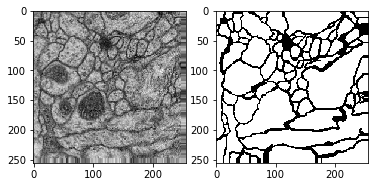

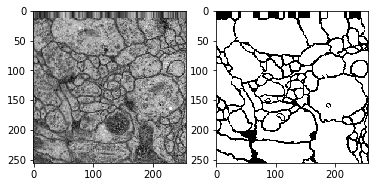

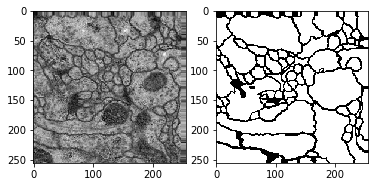

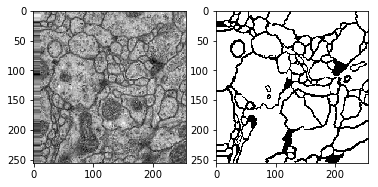

In [6]:
import matplotlib.pyplot as plt

# Generator image_number 
image_number  = 4
 
i = 0
for batch in myGene:
    print("len(batch): ", len(batch))
   
    imagem =batch[0][0][:,:,0]
    print("imagem: ", imagem.shape)
    
    mascara = batch[1][0][:,:,0]
    print("mascara: ", mascara.shape)
    
    
    f = plt.figure(i)
    
    f = plt.subplot(1,2,1)
    plt.imshow(imagem, cmap='gray')
    
    f = plt.subplot(1,2,2)
    plt.imshow(mascara, cmap='gray')

    i += 1
    if i % image_number  == 0:
        # It will loop indefinitely, so we need to `break` the loop at some point!
        break

plt.show()

## 1.3. Define Model 

## Auxiliar functions

### Define IoU metric


In [6]:
#import tensorflow as tf
def mean_iou(y_true, y_pred):
    
    prec = []
    
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    
    return K.mean(K.stack(prec), axis=0)

### Define dice metric

In [7]:
from keras import backend as K

def dice_coef(y_true, y_pred):
 
    y_true_f = K.flatten(Lambda(lambda y_true : y_true[:,:,1:])(y_true))
    y_pred_f = K.flatten(Lambda(lambda y_pred : y_pred[:,:,1:])(y_pred))
 
    smooth = 1 
       
    intersection = K.sum(y_true_f * y_pred_f)
    
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

### Define U-Net model
source: https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277

In [8]:
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.core import Dropout, Lambda
from keras.models import Model 
from keras.layers import Input
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate

def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    s = Lambda(lambda x: x / 255) (inputs)

    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    #Escolhe uma metrica 

    #print ("metrica: mean_iou")
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])

    print ("metrica: dice_coef")
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])

    return model

## 1.4. Trains the model

In [9]:
# Carrega o modelo da U-Net
model = unet()

metrica: dice_coef


In [10]:
#Mostra o modelo
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 160         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256, 256, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

In [11]:
from keras.callbacks import ModelCheckpoint

model_checkpoint = ModelCheckpoint('unet_model_weights.h5', monitor='loss',verbose=1, save_best_only=True)

#model.fit_generator(myGene,steps_per_epoch=2000,epochs=100,callbacks=[model_checkpoint])
model.fit_generator(myGene,steps_per_epoch=10,epochs=50,callbacks=[model_checkpoint])

Epoch 1/50
10/10 [==============================] - 128s 13s/step - loss: 0.5791 - dice_coef: 0.7338

Epoch 00001: loss improved from inf to 0.58361, saving model to unet_model_weights.h5
Epoch 2/50
10/10 [==============================] - 3s 251ms/step - loss: 0.6282 - dice_coef: 0.7170

Epoch 00002: loss did not improve
Epoch 3/50
10/10 [==============================] - 5s 541ms/step - loss: 0.5288 - dice_coef: 0.7822

Epoch 00003: loss improved from 0.58361 to 0.52932, saving model to unet_model_weights.h5
Epoch 4/50
10/10 [==============================] - 4s 429ms/step - loss: 0.5257 - dice_coef: 0.7785

Epoch 00004: loss improved from 0.52932 to 0.52567, saving model to unet_model_weights.h5
Epoch 5/50
10/10 [==============================] - 5s 549ms/step - loss: 0.5209 - dice_coef: 0.7813

Epoch 00005: loss improved from 0.52567 to 0.52165, saving model to unet_model_weights.h5
Epoch 6/50
10/10 [==============================] - 5s 504ms/step - loss: 0.5140 - dice_coef: 0.7854

Epoch 45/50
10/10 [==============================] - 5s 504ms/step - loss: 0.2212 - dice_coef: 0.9121

Epoch 00045: loss improved from 0.22106 to 0.22080, saving model to unet_model_weights.h5
Epoch 46/50
10/10 [==============================] - 5s 471ms/step - loss: 0.2199 - dice_coef: 0.9118

Epoch 00046: loss improved from 0.22080 to 0.21884, saving model to unet_model_weights.h5
Epoch 47/50
10/10 [==============================] - 5s 501ms/step - loss: 0.2149 - dice_coef: 0.9144

Epoch 00047: loss improved from 0.21884 to 0.21441, saving model to unet_model_weights.h5
Epoch 48/50
10/10 [==============================] - 5s 531ms/step - loss: 0.2111 - dice_coef: 0.9164

Epoch 00048: loss improved from 0.21441 to 0.21264, saving model to unet_model_weights.h5
Epoch 49/50
10/10 [==============================] - 6s 559ms/step - loss: 0.2110 - dice_coef: 0.9155

Epoch 00049: loss improved from 0.21264 to 0.21008, saving model to unet_model_weights.h5
Epoch 50/50
10/10 [================

## Evalutes the model

### Le modelo e pesos
Caso ainda não estejam na memoria

In [12]:
model = unet()

model.load_weights("unet_model_weights.h5")


metrica: dice_coef


### Gerador para o set de test,  sem data augmentation, mas normaliza as imagens

In [13]:
import skimage.io as io
import os
import skimage.transform as trans

def testGenerator(test_path,num_image = 30,target_size = (256,256),flag_multi_class = False,as_gray = True):
    
    for i in range(num_image):
        img = io.imread(os.path.join(test_path,"%d.png"%i),as_gray = as_gray)
        img = img / 255
        img = trans.resize(img,target_size, mode='constant')
        img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
        img = np.reshape(img,(1,)+img.shape)
        yield img

In [14]:
# Cria o gerador dando-lhe o caminho para as imagens
testGene = testGenerator(test_path = "data/membrane/test")

### Prevê o set de teste

In [15]:
# Podemos pedir ao gerador 10 imagens "steps = 10" do set de teste
# Guardamos as imagens previstas em "results"

results = model.predict_generator(testGene,steps = 10,verbose=1)

10/10 [==============================] - 0s 40ms/step


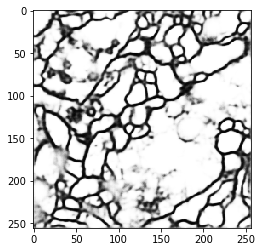

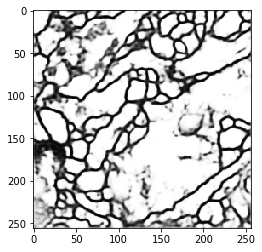

In [16]:
import matplotlib.pyplot as plt

# escolher o valor que a partir do qual pretendemos 4 iamgens do array
valor = 3

for i in range(2):
    f = plt.figure(i)
    plt.imshow(results[valor+i,:,:,0], cmap='gray')
    
plt.show()

In [17]:
# Vamos pedir ao gerador 5 imagens e mostrar os resultados da previsao

# Cria o gerador dando-lhe o caminho para as imagens
testGene = testGenerator(test_path = "data/membrane/test")


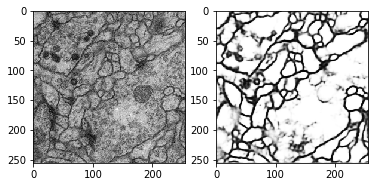

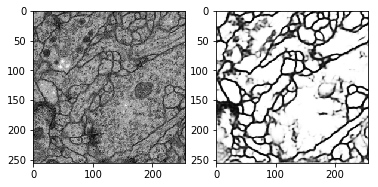

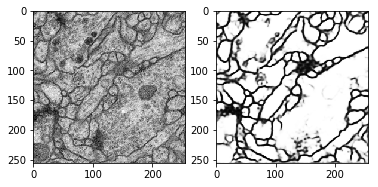

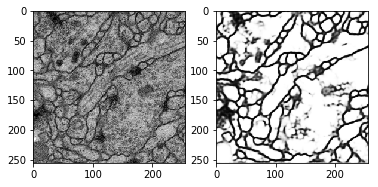

In [19]:
import matplotlib.pyplot as plt
 
i = 0
for img in testGene:
    
    img_prevista = model.predict(img)
    
    f = plt.figure(i)
    
    f = plt.subplot(1,2,1)
    plt.imshow(img[0,:,:,0], cmap='gray')
    
    f = plt.subplot(1,2,2)
    plt.imshow(img_prevista[0,:,:,0], cmap='gray')
    
    i = i +1
    
    if i >=4:
        break
    
plt.show()

# Já funciona! :)
# Desafio: Otimizar o modelo e aplica-o a um set diferente!!!